# Decision Trees and Random Forests

Previously we have looked in depth at a simple generative classifier (naive Bayes; see In Depth: Naive Bayes Classification) and a powerful discriminative classifier (support vector machines; see In-Depth: Support Vector Machines). Here we'll take a look at motivating another powerful algorithm—a non-parametric algorithm called random forests. Random forests are an example of an ensemble method, meaning that it relies on aggregating the results of an ensemble of simpler estimators. The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting! We will see examples of this in the following sections. We begin with the standard imports:

In [20]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Motivating Random Forests: Decision Trees

Rando mforests are an exmpale of an *ensemble learner* built on decisoin trees. For this reason we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or labels objects: you simple ask a series of questions designed to zero-in on the classification. For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

![decision_tree](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.08-decision-tree.png)

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut hte number of options by approximately half, very quickly narrowing hte options even among a large number of classes. The trick, of course, comes in deciding which question to ask at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the dat ainto two groups usinga cutoff value within one of the features. Let's now look at an example of this.

### Creatin ga decision tree

Consider the following two-dimensional data, which has one of four class labels:

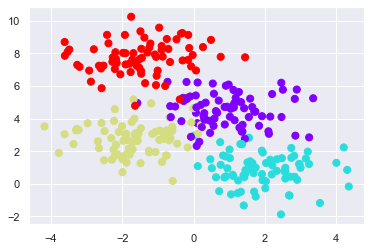

In [21]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. This figure presents a visualization of the first four levels of a decision tree classifier for this data:

![spliting_decision](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.08-decision-tree-levels.png)

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch. Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Sciit-Learn with the `DecisionTreeClassifier` estimator:

In [22]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Let's write a quick utility function to help us visualize the output of the classifier:

In [23]:
def visualize_classifier(model, X, y , ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
             clim=(y.min(), y.max()), zorder=3)
    
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)                         

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification looks like:

<ipython-input-23-83e205458e87>:21: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


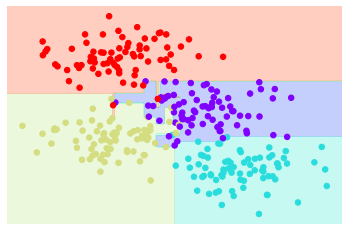

In [24]:
visualize_classifier(DecisionTreeClassifier(), X, y);

If you're runnig this notebook live, you can use the helpers script included to bring up an interactive visualization of the decison tree building process:

In [25]:
# # helpers_05_8 is found in the online appendix
# import helpers_05_08
# helpers_05_08.plot_tree_interactive(X, y)

Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions. It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data. That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

### Decision trees and over-fitting

Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from. Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

![decision_trees](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.08-decision-tree-overfitting.png)

It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters). The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from both of these trees, we might come up with a better result!
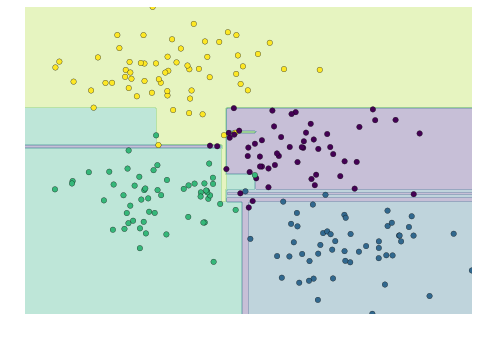

Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

## Ensembles of EStimators: Random Forests

This notion-that multiple overfitting estimators can be combined to reduce the effect of this overfitting-- is what underlies an enxempble method called *bagging*. Bagginf makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and avergaes the results to find a better classification. An ensemble of randomized decision trees is known as a *random forest.*

This type of bagging classification can be done manually using Scikit-Learn's `BaggingClassifier` meta-estimator, as shown here:

<ipython-input-23-83e205458e87>:21: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


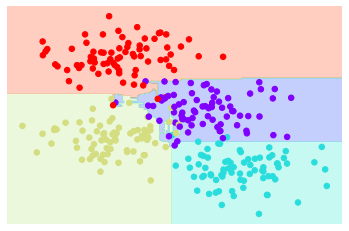

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)
bag.fit(X, y)
visualize_classifier(bag, X, y);

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness. For example, when determining which feature to split on, the randomized tree might select from among the top several features. You can read more technical details about these randomization strategies in the [Scikit-Learn](https://scikit-learn.org/stable/modules/ensemble.html#forest) documentation and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the `RandomForestClassifier` estimator, which takes care of all the randomization automatically. All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

<ipython-input-23-83e205458e87>:21: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


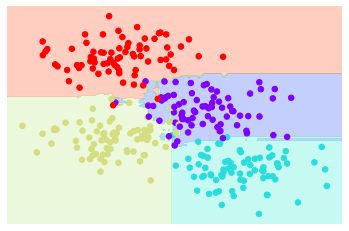

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.


## Random Forest Regression

In the prvious sectino we considered random forests within the context of classification. Random forests can aslo be made to work in the case of regression. The estimator to use for this is the `RandomForestRegressor`, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

<ErrorbarContainer object of 3 artists>

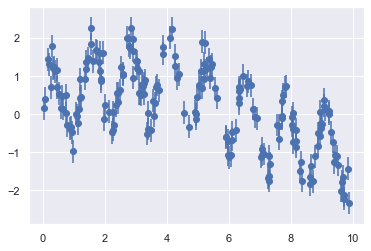

In [29]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o')

Using the random forest regressor, we can find the best fit curve as follows:

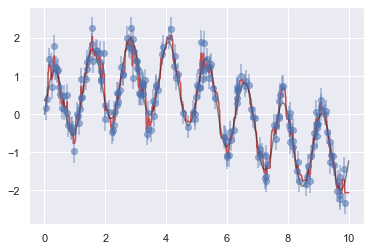

In [36]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is hown in the smooth gray curve, while hte rnadom forest model is shown by the jagged red curve. As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specigying a multi-period model!